Source code: Chatgpt

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras_tuner as kt
import tensorflow as tf
import random

In [2]:
directory = '../Data/Data train-test'

train_df = pd.read_csv(f"{directory}/train.csv",index_col='Date', parse_dates=True)
test_df = pd.read_csv(f"{directory}/test.csv",index_col='Date', parse_dates=True)
train_df.head()

,AAPL,META,MSFT,GOOG,AMZN,TSLA
Date,,,,,,
2015-01-02,27.332500,78.449997,46.759998,523.37306,308.52,43.862001
2015-01-05,26.562500,77.190002,46.330002,512.46304,302.19,42.018000
2015-01-06,26.565001,76.150002,45.650002,500.58564,295.29,42.255999
2015-01-07,26.937500,76.150002,46.230000,499.72802,298.42,42.189999
2015-01-08,27.972500,78.180000,47.590000,501.30368,300.46,42.123999


# Google stock

In [3]:
# Keep only apple stocks
train_data = train_df[['GOOG']]
test_data = test_df[['GOOG']]


In [4]:
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

## Fearure Scaling

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)


## Create Sequences for LSTM

In [6]:
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 40
X_train, y_train = create_sequences(train_scaled, time_step)

# Reshape the data to be suitable for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


## Build and Compile the LSTM Model

### Perform hyperparameter tuning with Keras tuner

Use random search with search space:\
unit: 50, 100, 150, 200\
learning rate: 0.1, 0.01, 0.001

In [7]:
# Create a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dense(units=1))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='mean_squared_error')
    return model


In [8]:
# Use Keras Tuner to search for the best hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_Google_prediction'
)

tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the details of the best hyperparameters
print(f"""
The optimal number of units is {best_hps.get('units')} and 
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Reloading Tuner from my_dir\lstm_Google_prediction\tuner0.json

The optimal number of units is 50 and 
the optimal learning rate for the optimizer is 0.001.



The optimal number of units is 50 and \
the optimal learning rate for the optimizer is 0.001.


## Fitting model with best hyperparameters

In [9]:
# Build the model with the optimal hyperparameters
model = build_model(best_hps)
model.summary()


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0817
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0026
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0013
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0012
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0012
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0012
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0012
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0012
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0011
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0011
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0011
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0011
Epoch 13/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0011
Epoch 14/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011
Epoch 15/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - lo

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.0039e-04
Epoch 80/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.9843e-04
Epoch 81/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.9659e-04
Epoch 82/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 3.9483e-04
Epoch 83/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.9312e-04
Epoch 84/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.9144e-04
Epoch 85/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.8979e-04
Epoch 86/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.8814e-04
Epoch 87/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.8651e-04
Epoch 88/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.8488e-04
Epoch 89/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.8326e-04
Epoch 90/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.8167e-04
Epoch 91/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.8012e-04
Epoch 92/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.7863e-04
Epoch

In [11]:
# Prepare data for prediction that included test data and last 60 observations of train data
pre_data = pd.concat([train_data.tail(40), test_data])


In [12]:
# data scaling, create sequence and reshape
test_scaled = scaler.transform(pre_data)
X_test, y_test = create_sequences(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [13]:
# Prediction 
y_pred = model.predict(X_test)

# Invert the scaling to get actual prices
y_pred_actual = scaler.inverse_transform(y_pred)

# Add predicted prices to the test dataset as a dataframe
test_data['Predicted Prices'] = np.nan  
test_data.iloc[:, -1] = y_pred_actual.flatten()  


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_17360\974272790.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Prices'] = np.nan


In [14]:
test_data.head()

,GOOG,Predicted Prices
Date,,
2020-01-02,1367.37000,1357.434570
2020-01-03,1360.65994,1390.878296
2020-01-06,1394.21006,1376.193726
2020-01-07,1393.34000,1419.754395
2020-01-08,1404.32006,1408.571289


In [15]:
# Calculate MSE, RMSE, and MAPE for the full test set
mse = mean_squared_error(test_data['GOOG'], test_data['Predicted Prices'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data['GOOG'] - test_data['Predicted Prices']) / test_data['GOOG'])) * 100
mae = mean_absolute_error(test_data['GOOG'], test_data['Predicted Prices'])

# Print evaluation metrics for the full test set
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE) for full test set: {rmse}")
print(mape)

Mean Absolute Error (MAE): 29.918564759894274
Root Mean Squared Error (RMSE) for full test set: 40.82644546769872
1.9182150404308755


Mean Absolute Error (MAE): 29.918564759894274\
Root Mean Squared Error (RMSE) for full test set: 40.82644546769872

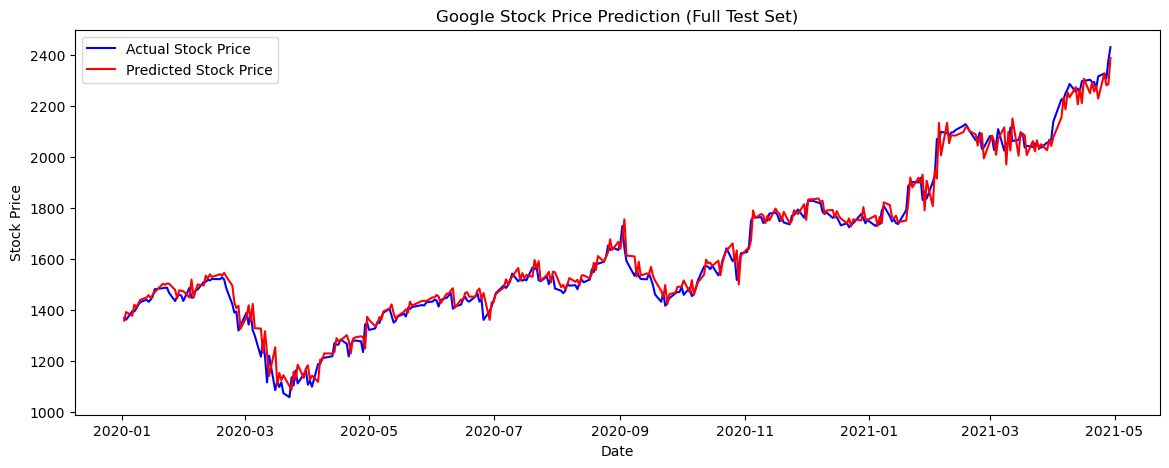

In [16]:
# Plot actual vs predicted prices for the full test set
plt.figure(figsize=(14, 5))
plt.plot(test_data.index, test_data['GOOG'], color='blue', label='Actual Stock Price')
plt.plot(test_data.index, test_data['Predicted Prices'], color='red', label='Predicted Stock Price')
plt.title('Google Stock Price Prediction (Full Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()